# 1.Initial setup

## Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from collections import Counter
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gensim
from sklearn.metrics import precision_score as sk_precision
from sklearn.metrics import f1_score
import seaborn as sns

SEED = 9999

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Connect to Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

root_folder = '/content/drive/MyDrive/nlp_hw1'

Mounted at /content/drive


# 2. Dataset Class

The dataset class takes in input a jsonl file and extract all the sentences list and tags list from it.
The train dataset instance is the one responsible for creating the vocabulary (word2idx)

In [46]:
class Dataset():
  def __init__(self, data_path, wv_model):
    self.wv_model = wv_model
    self.raw_tokens_data = []
    self.raw_tags_data = []
    self.sentences, self.tags = self.read_data(data_path)
    self.tokens_vocabulary, self.tags_vocabulary, self.index2word, self.index2tag = self.to_index(self.sentences, self.tags)


  def read_data(self, train_path):
    data = []
    sentences = []
    tags = []

    with open(train_path) as f:
      data = [json.loads(line) for line in f]

    for elem in data:
      sentences.append(elem['tokens'])
      tags.append(elem['labels'])
      self.raw_tokens_data.extend(elem['tokens'])
      self.raw_tags_data.extend(elem['labels'])

    
    return sentences, tags

  
  def to_index(self, sentences, tags):
    tokens_vocabulary = {'<UNK_TOKEN>' : 0}
    tags_vocabulary = {}
    for sentence in sentences:
      for word in sentence:
        if word not in tokens_vocabulary:
          if word in self.wv_model:
            tokens_vocabulary[word] = self.wv_model.key_to_index[word]
    
    for taglist in tags:
      for tag in taglist:
        if tag not in tags_vocabulary:
          tags_vocabulary[tag] = len(tags_vocabulary)

    index2word = {v: k for k, v in tokens_vocabulary.items()}
    index2tag = {v: k for k, v in tags_vocabulary.items()}

    return tokens_vocabulary, tags_vocabulary, index2word, index2tag

  def encode_sentence(self, sentence):
    encoded_sentence = [self.tokens_vocabulary[word] if word in self.tokens_vocabulary else 0 for word in sentence]
    return encoded_sentence

  def encode_tags(self, tags):
    encoded_tags = [self.tags_vocabulary[tag] for tag in tags]
    return encoded_tags  

  def decode_sentence(self, sentence):
    decoded_sentence = [self.index2word[word] for word in sentence]
    return decoded_sentence
  
  def decode_taglist(self, taglist):
    decoded_taglist = [self.index2tag[tag] for tag in taglist]
    return decoded_taglist

In [9]:
wv_model = gensim.models.KeyedVectors.load_word2vec_format("/content/drive/MyDrive/nlp_hw1/GoogleNews-vectors-negative300.bin", binary=True)

## Creating the datasets

In [47]:
dataset = Dataset(data_path = "/content/drive/MyDrive/nlp_hw1/train.jsonl",wv_model = wv_model)
validation_dataset = Dataset(data_path = "/content/drive/MyDrive/nlp_hw1/dev.jsonl", wv_model = wv_model)

In [11]:
print(dataset.tokens_vocabulary)

{'<UNK_TOKEN>': 0, 'Hard': 12033, 'Rock': 3632, 'Hell': 14312, 'III': 4587, 'The': 7, 'Vikings': 4937, 'Ball': 6375, 'Casualties': 74389, 'damage': 1248, 'were': 37, 'severe': 2670, 'on': 5, 'both': 184, 'sides': 1726, 'the': 11, 'defiance': 15656, 'French': 1209, 'ship': 2666, 'was': 10, 'celebrated': 4384, 'in': 1, 'countries': 523, 'as': 14, 'brave': 8435, 'against': 103, 'overwhelming': 6140, 'odds': 4577, 'This': 105, 'incident': 1291, 'led': 363, 'violence': 1167, 'Al': 4346, 'Anbar': 30628, 'Governorate': 172569, 'between': 171, 'Iraqi': 1290, 'Army': 1685, 'loose': 4516, 'alliance': 4074, 'tribal': 6155, 'militias': 13758, 'other': 66, 'groups': 756, 'fighting': 1385, 'alongside': 3501, 'Islamic': 2941, 'State': 268, 'Iraq': 477, 'Levant': 73981, 'ISIL': 376080, 'As': 232, 'aspects': 3935, 'crisis': 990, 'relation': 6612, 'militants': 2877, 'continue': 395, 'be': 16, 'contentious': 9849, 'questions': 992, 'remain': 872, 'regarding': 1785, 'how': 139, 'many': 131, 'terrorists': 

In [12]:
print(dataset.tags_vocabulary)

{'O': 0, 'B-SCENARIO': 1, 'B-CHANGE': 2, 'B-ACTION': 3, 'B-SENTIMENT': 4, 'I-CHANGE': 5, 'B-POSSESSION': 6, 'I-ACTION': 7, 'I-SENTIMENT': 8, 'I-SCENARIO': 9, 'I-POSSESSION': 10}


# 3. BiLSTM

In [27]:
# Bi-LSTM Architecture inspired by your colab notebook
class BiLSTMEventDetector(nn.Module):

    def __init__(self,
                 embedding_dim,
                 weights,
                 hidden_dim,
                 output_dim,
                 lstm_layers,
                 emb_dropout,
                 lstm_dropout,
                 fc_dropout):

        super().__init__()

        self.embedding_dim = embedding_dim

        self.embedding = nn.Embedding.from_pretrained(embeddings=weights)

        self.emb_dropout = nn.Dropout(emb_dropout)

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            bidirectional=True,
            dropout=lstm_dropout
        )

        self.fc_dropout = nn.Dropout(fc_dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, sentence):
        embedding_out = self.emb_dropout(self.embedding(sentence))
        lstm_out, _ = self.lstm(embedding_out)
        lstm_out = self.fc_dropout(lstm_out)
        tag_space = self.fc(lstm_out)
        return tag_space


## Define the Bi-LSTM hyperparameters and create the model


In [15]:
EMBEDDING_DIM = 300
HIDDEN_DIM = 350
OUTPUT_DIM = 11
weights = torch.FloatTensor(wv_model.vectors)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lstm_model = BiLSTMEventDetector(EMBEDDING_DIM, weights, HIDDEN_DIM, OUTPUT_DIM,
                                 lstm_layers = 2, emb_dropout = 0.2, lstm_dropout = 0.2,
                                 fc_dropout = 0.2).to(device)

# 3. Training


## Loss function and optimizer

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters())

In [ ]:
print(lstm_model)

total_params = sum(p.numel() for p in lstm_model.parameters() if p.requires_grad)
print("Number of trainable parameters in the LSTM: ", total_params)

BiLSTMEventDetector(
  (embedding): Embedding(3000000, 300)
  (emb_dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(300, 350, num_layers=2, dropout=0.2, bidirectional=True)
  (fc_dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=700, out_features=11, bias=True)
)
Number of trainable parameters in the LSTM:  4778911


## Some aux functions

In [6]:
def compute_accuracy(targets, predicted_indices):
    accuracy = sk_precision(targets.cpu(), predicted_indices.cpu(), average="macro", zero_division=0)
    return accuracy

In [5]:
def compute_f1(targets, predicted_indices):
  f1 = f1_score(targets.cpu(), predicted_indices.cpu(), average="macro")
  return f1

## Let's start the training loop

In [ ]:
epochs = 15

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

train_loss_list = []
train_f1_list = []
train_micro_precision_list = []
val_f1_list = []
val_micro_precision_list = []


for epoch in range(epochs):
  epoch_loss = 0.0
  epoch_accuracy = 0.0
  epoch_f1 = 0.0

  lstm_model.train()

  for i in range(len(dataset.sentences)):
    sentence = dataset.sentences[i]
    tags = dataset.tags[i]

    lstm_model.zero_grad()

    sentence_in = torch.tensor(dataset.encode_sentence(sentence), dtype=torch.long).to(device)
    targets = torch.tensor(dataset.encode_tags(tags), dtype=torch.long).to(device)

    tag_scores = lstm_model(sentence_in)

    loss = loss_function(tag_scores.view(-1, tag_scores.shape[-1]), targets.view(-1))

    _, indices = torch.max(tag_scores, 1)

    epoch_loss += loss.item()
    epoch_accuracy += compute_accuracy(targets, indices)
    epoch_f1 += compute_f1(targets, indices, len(sentence))

    loss.backward()

    optimizer.step()
  
  print("Epoch {}, loss: {}, accuracy: {}, f1_score: {}".format(epoch+1, epoch_loss/len(dataset.sentences), epoch_accuracy/len(dataset.sentences), epoch_f1 / len(dataset.sentences)))

  print("Validation...")
  with torch.no_grad():
    lstm_model.eval()
    val_accuracy = 0.0
    predictions = []
    gold = []
    for i in range(len(validation_dataset.sentences)):
      sentence = validation_dataset.sentences[i]
      tags = validation_dataset.tags[i]

      sentence_in = torch.tensor(dataset.encode_sentence(sentence), dtype=torch.long).to("cuda")
      targets = torch.tensor(dataset.encode_tags(tags), dtype=torch.long).to("cuda")

      tag_scores = lstm_model(sentence_in)
      _, indices = torch.max(tag_scores, 1)

      predictions.extend(indices)
      gold.extend(targets)

      val_accuracy += compute_accuracy(targets, indices)

    print("Validation Accuracy: ", val_accuracy / len(validation_dataset.sentences))
    f1 = f1_score(torch.tensor(gold).cpu(), torch.tensor(predictions).cpu(), average="macro")
    print("Macro-f1: ", f1)
    print("Macro-Precision: ", sk_precision(torch.tensor(gold).cpu(), torch.tensor(predictions).cpu(), average="macro", zero_division=0))
    print("Micro-Precision: ", sk_precision(torch.tensor(gold).cpu(), torch.tensor(predictions).cpu(), average="micro", zero_division=0))



In [24]:
#torch.save(lstm_model.state_dict(), "/content/drive/MyDrive/nlp_hw1/lstm_model_350_final.pt")

#5.Test

In [48]:
test_dataset = Dataset(data_path = "/content/drive/MyDrive/nlp_hw1/test.jsonl", wv_model = wv_model)

In [28]:
loaded_model = BiLSTMEventDetector(EMBEDDING_DIM, weights, HIDDEN_DIM, OUTPUT_DIM,
                                 lstm_layers = 2, emb_dropout = 0.25, lstm_dropout = 0.25,
                                 fc_dropout = 0.25).to(device)

loaded_model.load_state_dict(torch.load("/content/drive/MyDrive/nlp_hw1/lstm_single_vfinal[BEST].pt", map_location=torch.device('cpu')))

print(loaded_model)

BiLSTMEventDetector(
  (embedding): Embedding(3000000, 300)
  (emb_dropout): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(300, 350, num_layers=2, dropout=0.25, bidirectional=True)
  (fc_dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=700, out_features=11, bias=True)
)


In [74]:
test_accuracy = 0.0
predictions = []
gold = []

loaded_model.eval()

for i in range(len(test_dataset.sentences)):
  sentence = test_dataset.sentences[i]
  tags = test_dataset.tags[i]

  sentence_in = torch.tensor(dataset.encode_sentence(sentence), dtype=torch.long).to("cpu")
  targets = torch.tensor(dataset.encode_tags(tags), dtype=torch.long).to("cpu")

  tag_scores = loaded_model(sentence_in)
  _, indices = torch.max(tag_scores, 1)

  #print("gold = ", targets)
  #print("pred = ", indices)
  #print("\n")

  predictions.extend(indices.tolist())
  gold.extend(targets.tolist())


print("Macro Precision: ", sk_precision(gold, predictions, average="macro", zero_division=0))
print("Micro Precision: ", sk_precision(gold, predictions, average="micro", zero_division=0))
f1 = f1_score(gold, predictions, average="macro")
print("Macro f1-score: ", f1)


Macro Precision:  0.7157190292709101
Micro Precision:  0.9491105955143078
Macro f1-score:  0.7213653983337103


# Prediction Confusion Matrix

Counter({('I-POSSESSION', 'I-POSSESSION'): 1.0, ('O', 'O'): 0.97, ('I-SCENARIO', 'I-SCENARIO'): 0.96, ('I-CHANGE', 'I-CHANGE'): 0.84, ('B-CHANGE', 'B-CHANGE'): 0.79, ('B-SCENARIO', 'B-SCENARIO'): 0.78, ('B-POSSESSION', 'B-POSSESSION'): 0.78, ('B-ACTION', 'B-ACTION'): 0.68, ('B-SENTIMENT', 'B-SENTIMENT'): 0.65, ('I-ACTION', 'I-ACTION'): 0.62, ('I-SENTIMENT', 'I-SENTIMENT'): 0.5, ('I-SENTIMENT', 'O'): 0.5, ('B-SENTIMENT', 'O'): 0.28, ('B-ACTION', 'O'): 0.27, ('I-ACTION', 'O'): 0.22, ('B-SCENARIO', 'O'): 0.16, ('B-CHANGE', 'O'): 0.15, ('B-POSSESSION', 'O'): 0.15, ('I-CHANGE', 'O'): 0.08, ('I-CHANGE', 'I-ACTION'): 0.08, ('I-ACTION', 'B-ACTION'): 0.06, ('I-ACTION', 'I-CHANGE'): 0.06, ('B-SENTIMENT', 'B-ACTION'): 0.04, ('I-SCENARIO', 'O'): 0.04, ('I-ACTION', 'I-SCENARIO'): 0.04, ('B-ACTION', 'B-CHANGE'): 0.03, ('B-CHANGE', 'B-ACTION'): 0.03, ('B-SCENARIO', 'B-ACTION'): 0.03, ('B-POSSESSION', 'B-ACTION'): 0.03, ('B-POSSESSION', 'B-CHANGE'): 0.03, ('B-CHANGE', 'B-SCENARIO'): 0.02, ('B-SCENARIO

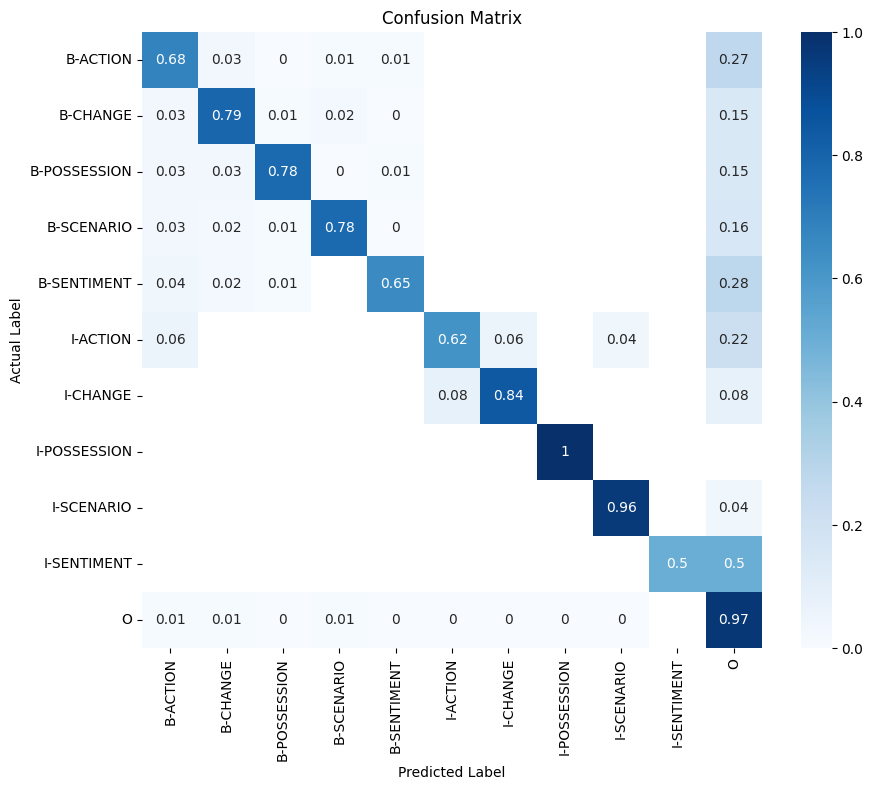

In [77]:
gold_decoded = dataset.decode_taglist(gold)
predictions_decoded = dataset.decode_taglist(predictions)
couples = zip(gold_decoded, predictions_decoded)
counter = Counter(couples)
for elem in counter:
  count = gold_decoded.count(elem[0])
  if count != 0:
    counter[elem] = round(counter[elem] / count, 2)
  else:
    counter[elem] = 0
print(counter)

confusion_df = pd.DataFrame(list(counter.items()), columns=['Actual-Predicted', 'Count'])
confusion_df[['Actual', 'Predicted']] = pd.DataFrame(confusion_df['Actual-Predicted'].tolist(), index=confusion_df.index)

confusion_matrix_df = confusion_df.pivot(index='Actual', columns='Predicted', values='Count')

plt.figure(figsize=(10, 8))

ax = sns.heatmap(confusion_matrix_df, annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

plt.show()